# Relax Data Science Challenge

## Overview of Data and Goals

In this scenario, I will be looking into two data sets, takehome_users and takehome_users_engagement. The takehome_users data includes these variables:
* **name**: the user's name
* **object_id**: the user's id
* **email**: email address
* **creation_source**: how their account was created. This takes on one of 5 values:
     - **PERSONAL_PROJECTS**: invited to join another user's personal workspace
     - **GUEST_INVITE**: invited to an organization as a guest (limited permissions)
     - **ORG_INVITE**: invited to an organization (as a full member)
     - **SIGNUP**: signed up via the website
     - **SIGNUP_GOOGLE_AUTH**: signed up using Google Authentication (using a Google email account for their login id)
* **creation_time**: when they created their account
* **last_session_creation_time**: unix timestamp of last login
* **opted_in_to_mailing_list**: whether they have opted into receiving marketing emails
* **enabled_for_marketing_drip**: whether they are on the regular marketing email drip
* **org_id**: the organization (group of users) they belong to
* **invited_by_user_id**: which user invited them to join (if applicable).

While the takehome_users_engagement has data indicating when users log in. There is a row for each day that the user logs in. 

The company has deemed an adopted user, a user that has logged in 3 separate days in a 7 day window. I want to identify which features of the data are more influential in predicting user adoption.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
users = pd.read_csv('takehome_users.csv', engine = 'python')
users_engagement = pd.read_csv('takehome_user_engagement.csv', engine = 'python')

In [5]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [8]:
# Need to make date time objects for date time variables
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [9]:
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit = 's')

In [10]:
# Need to fill NA values, can assume that if there isnt a last_session that the initial creation is the last session
users['last_session_creation_time'] = users['last_session_creation_time'].fillna(users['creation_time'])

In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [6]:
users_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [12]:
users_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [13]:
# need to make time stamp info a date time object
users_engagement['time_stamp'] = pd.to_datetime(users_engagement['time_stamp'])

In [17]:
# since all of the visited column is a 1 it is unnecessary for analysis
users_engagement = users_engagement.drop('visited', axis = 1)

In [18]:
users_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.2 MB


### Identifying which users are considered adopted users

In [19]:
adopted_users = np.zeros(len(users)).astype('bool')
seven_days = np.timedelta64(7, 'D')

In [24]:
for i in users.object_id:
    login_timestamps = np.sort(users_engagement.time_stamp[users_engagement.user_id == i].values)
    if len(login_timestamps) >= 3:
        adopted_users[i - 1] = ((login_timestamps[2:] - login_timestamps[0:-2]) <= seven_days).any()

In [25]:
adopted_users = pd.Series(adopted_users, name = 'adopted_users')

In [26]:
print(adopted_users)

0        False
1         True
2        False
3        False
4        False
         ...  
11995    False
11996    False
11997    False
11998    False
11999    False
Name: adopted_users, Length: 12000, dtype: bool


In [29]:
email_domain = users.email.map(lambda s: s[s.index("@") + 1 :])
email_domain.name = "email_domain"

email_domain_adopt = pd.concat([email_domain, adopted_users], axis=1).pivot_table(index="email_domain", values="adopted_users", aggfunc=[len, np.sum, lambda x: np.sum(x) / len(x)])
email_domain_adopt.columns = ["total_count", "adopted_count", "adopted_rate"]
email_domain_adopt = email_domain_adopt.sort_values(["adopted_rate", "adopted_count", "total_count"], ascending=False)

email_domain_adopt_rest = email_domain_adopt[email_domain_adopt.total_count <= 10]
email_domain_adopt = email_domain_adopt[email_domain_adopt.total_count > 10]

email_domain_adopt_others = np.sum(email_domain_adopt_rest)
email_domain_adopt_others.adopted_rate = email_domain_adopt_others.adopted_count / email_domain_adopt_others.total_count
email_domain_adopt_others.name = "others"
email_domain_adopt = email_domain_adopt.append(email_domain_adopt_others)
email_domain_adopt

,total_count,adopted_count,adopted_rate
email_domain,,,
hotmail.com,1165.0,205.0,0.175966
gmail.com,3562.0,557.0,0.156373
jourrapide.com,1259.0,170.0,0.135028
gustr.com,1179.0,150.0,0.127226
cuvox.de,1202.0,144.0,0.119800
yahoo.com,2447.0,267.0,0.109113
others,1186.0,163.0,0.137437


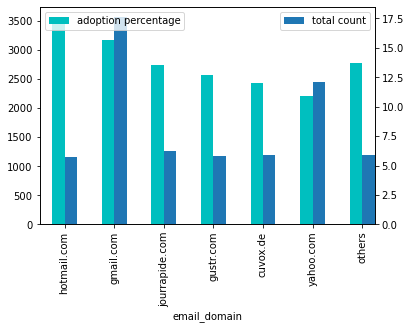

In [30]:
plt.figure()

ax1 = plt.gca()
ax2 = ax1.twinx()

email_domain_adopt.total_count.plot.bar(label = 'total count', position = 0, width = 0.25, ax = ax1)
(email_domain_adopt.adopted_rate*100).plot.bar(label = 'adoption percentage', color = 'c', position = 1, width = 0.25, ax = ax2)
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper left')

We can see from the above graphic that there is a difference seen in adoption rate between email domains

In [31]:
adopt_table = pd.concat([(email_domain_adopt.total_count - email_domain_adopt.adopted_count), email_domain_adopt.adopted_count], axis=1)
adopt_table.columns = ["nonadopted_count", "adopted_count"]
adopt_table

,nonadopted_count,adopted_count
email_domain,,
hotmail.com,960.0,205.0
gmail.com,3005.0,557.0
jourrapide.com,1089.0,170.0
gustr.com,1029.0,150.0
cuvox.de,1058.0,144.0
yahoo.com,2180.0,267.0
others,1023.0,163.0


While hotmail has the lowest total count of email domains, hotmail has the highest percentage of adoption as seen above

For this chi^2 test, the null Hypothesesis is that the email domain and adoption occurrence are independant. The alternate hypothesis is that the email domain and adoption occurrence are not independant

In [32]:
# want to do chi2 tests to look at independance
from scipy.stats import chi2_contingency
_, p, _, _ = chi2_contingency(adopt_table)
print('P-value of chi2 test: {}'.format(p))

P-value of chi2 test: 2.983360416428637e-08


With a P-value of 2.98 e-08, we can safely reject the null hypothesis and conclude that email domain and adoption occurrence are not independant

In [39]:
from copy import deepcopy

email_domain_feature = deepcopy(email_domain)
for i, x in enumerate(email_domain_feature):
    if x not in email_domain_adopt.index:
        email_domain_feature[i] = "others"
        
email_domain_feature

0          yahoo.com
1          gustr.com
2          gustr.com
3          yahoo.com
4          yahoo.com
            ...     
11995      gustr.com
11996      gmail.com
11997       cuvox.de
11998         others
11999    hotmail.com
Name: email_domain, Length: 12000, dtype: object

### Creation Source Analysis

In [35]:
creation_adopt = pd.concat([users['creation_source'], adopted_users], axis = 1).pivot_table(index = 'creation_source',values = 'adopted_users', aggfunc=[len, np.sum, lambda x: np.sum(x) / len(x)])
creation_adopt.columns = ['total_count','adopted_count','adopted_rate']
creation_adopt = creation_adopt.sort_values(['adopted_rate','adopted_count','total_count'], ascending = False)

creation_adopt

,total_count,adopted_count,adopted_rate
creation_source,,,
SIGNUP_GOOGLE_AUTH,1385,239,0.172563
GUEST_INVITE,2163,369,0.170596
SIGNUP,2087,302,0.144705
ORG_INVITE,4254,574,0.134932
PERSONAL_PROJECTS,2111,172,0.081478


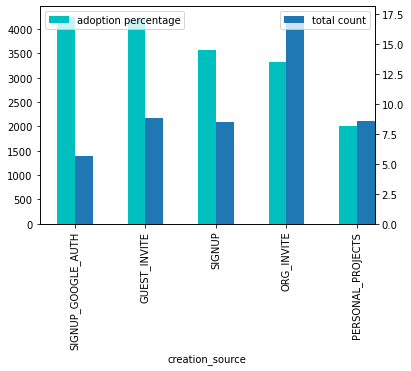

In [36]:
plt.figure()

ax1 = plt.gca()
ax2 = ax1.twinx()

creation_adopt.total_count.plot.bar(label = 'total count', position = 0, width = 0.25, ax = ax1)
(creation_adopt.adopted_rate*100).plot.bar(label = 'adoption percentage', color = 'c', position = 1, width = 0.25, ax = ax2)
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper left')

From the above plot we can see that the percentage of adoption is highest for Signup_Google_Auth thought it has the lowest count, a similar situtation as seen above with email domains

In [37]:
creation_adopt_table = pd.concat([(creation_adopt.total_count - creation_adopt.adopted_count), creation_adopt.adopted_count], axis=1)
creation_adopt_table.columns = ["nonadopted_count", "adopted_count"]
creation_adopt_table

,nonadopted_count,adopted_count
creation_source,,
SIGNUP_GOOGLE_AUTH,1146,239
GUEST_INVITE,1794,369
SIGNUP,1785,302
ORG_INVITE,3680,574
PERSONAL_PROJECTS,1939,172


Again I would like to run a chi square test to determine whether creation_source is independant of user adoption.

The null hypothesis is that creation source is independant of user adoption
The alternate hypothesis is that the creation source is not independant of user adoption

In [38]:
# want to do chi2 tests to look at independance
_, p, _, _ = chi2_contingency(creation_adopt_table)
print('P-value of chi2 test: {}'.format(p))

P-value of chi2 test: 7.884346873316259e-19


With a p value of 7.88 e-19, it is safe to reject the null hypothesis and conclude that creation source and user adoption are not independant

In [41]:
creation_feature = deepcopy(users['creation_source'])
creation_feature

0              GUEST_INVITE
1                ORG_INVITE
2                ORG_INVITE
3              GUEST_INVITE
4              GUEST_INVITE
                ...        
11995            ORG_INVITE
11996    SIGNUP_GOOGLE_AUTH
11997          GUEST_INVITE
11998     PERSONAL_PROJECTS
11999                SIGNUP
Name: creation_source, Length: 12000, dtype: object

### Last Login Session

In [43]:
last_login_since_creation = (users.last_session_creation_time - users.creation_time)
last_login_since_creation.name = "last_login_since_first"
last_login_since_creation_adopt = pd.concat([last_login_since_creation, adopted_users], axis=1).pivot_table(index="adopted_users", aggfunc=lambda x: np.mean(x))
last_login_since_creation_adopt

,last_login_since_first
adopted_users,
False,3 days 16:27:17.122969837
True,292 days 12:11:18.260869564


Text(0.5, 0, 'last_session_since_first [day]')

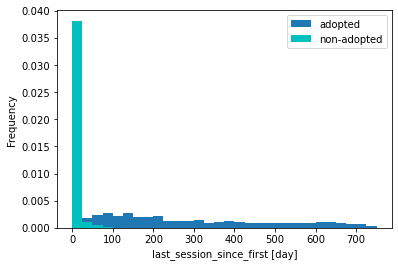

In [45]:
last_login_since_creation[adopted_users].dt.days.plot.hist( density=True, bins=np.linspace(0, 750, 31), label="adopted")
last_login_since_creation[~adopted_users].dt.days.plot.hist(color="c", density=True, bins=np.linspace(0, 750, 31), label="non-adopted")
plt.legend()
plt.xlabel("last_session_since_first [day]")

We can see that there is a large difference in distribution between the adopted and non adopted users, we can take a log of this data to get a clearer picture

Text(0.5, 0, 'log(x+1) of last_session_since_first [arbitary unit]')

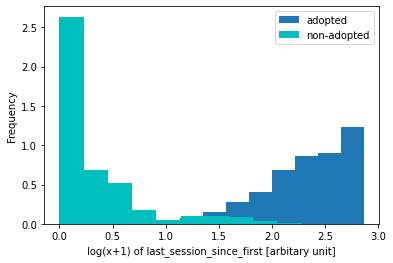

In [46]:
np.log10(last_login_since_creation.dt.days + 1)[adopted_users].plot.hist( density=True, label="adopted")
np.log10(last_login_since_creation.dt.days + 1)[~adopted_users].plot.hist(color="c", density=True, label="non-adopted")
plt.legend()
plt.xlabel("log(x+1) of last_session_since_first [arbitary unit]")

We can see that the log(x + 1) transformation has made the distributions more manageable, and have more normal qualities

In this scenario since we are dealing with numeric values opposed to categorical, to test independance of variables a t-test should be used 

The null hypothesis is that the last login is independant of adopted users.
The alternate hypothesis is that the last login is not indpendant of adopted users.

In [47]:
from scipy.stats import ttest_ind

x = np.log10(last_login_since_creation.dt.days + 1)[adopted_users].values
y = np.log10(last_login_since_creation.dt.days + 1)[~adopted_users].values

_, p = ttest_ind(x, y)
print("P-value of t test: {}".format(p))

P-value of t test: 0.0


With a p-value of 0, we can safely reject the null hypothesis and conclude that the last login is not indpendant of adopted users

In [48]:
last_login_feature = last_login_since_creation.dt.days
last_login_feature

0          0
1        136
2          0
3          1
4          5
        ... 
11995      0
11996      5
11997      0
11998      2
11999      0
Name: last_login_since_first, Length: 12000, dtype: int64

### Opted In for Mailing

In [50]:
print("Adoption rate - opted into mailing list")
pd.crosstab(adopted_users, users.opted_in_to_mailing_list, normalize="columns")

Adoption rate - opted into mailing list


opted_in_to_mailing_list,0,1
adopted_users,,
False,0.863757,0.856713
True,0.136243,0.143287


This chart shouls that there is less than a 1% difference in adopted users who opted into the mailing list and those that did not opt into the adopted users

### Organization ID

In [53]:
org_adopt = pd.concat([users.org_id, adopted_users], axis=1).groupby("org_id").aggregate([len, np.sum, np.mean])
org_adopt.columns = ["total_count", "adopted_count", "adopted_rate"]
org_adopt = org_adopt.sort_values(["adopted_rate", "adopted_count", "total_count"], ascending=False)

org_adopt_rest = org_adopt[org_adopt.total_count <= 10]
org_adopt = org_adopt[org_adopt.total_count > 10]

org_adopt_others = org_adopt_rest.sum()
org_adopt_others.adopted_rate = org_adopt_others.adopted_count / org_adopt_others.total_count
org_adopt_others.name = "others"
org_adopt = org_adopt.append(org_adopt_others)
org_adopt

,total_count,adopted_count,adopted_rate
org_id,,,
387,12.0,7.0,0.583333
235,13.0,6.0,0.461538
270,14.0,6.0,0.428571
399,13.0,5.0,0.384615
392,16.0,6.0,0.375000
...,...,...,...
329,13.0,0.0,0.000000
346,12.0,0.0,0.000000
183,11.0,0.0,0.000000


Text(0, 0.5, 'adopted percantage')

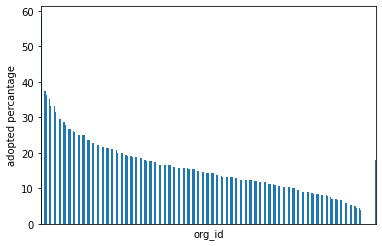

In [54]:
(org_adopt.adopted_rate * 100).plot.bar()
plt.xticks([])
plt.ylabel("adopted percantage")

Different organization have different adoption rates, and any org that has less than 10 users has been aggregated into other

In [55]:
org_id_feature = deepcopy(users.org_id)
for i, x in enumerate(org_id_feature):
    if x not in org_adopt.index:
        org_id_feature[i] = "others"
        
org_id_feature

0         11
1          1
2         94
3          1
4        193
        ... 
11995     89
11996    200
11997     83
11998      6
11999      0
Name: org_id, Length: 12000, dtype: object

### If the user was invited

In [57]:
invited = ~users.invited_by_user_id.isnull()
invited.name = "invited"

print("Adoption rate - if users are invited")
pd.crosstab(adopted_users, invited, normalize="columns")

Adoption rate - if users are invited


invited,False,True
adopted_users,,
False,0.872291,0.853047
True,0.127709,0.146953


We see that there is a slight difference in adoption from individuals who were invited vs users who were not invited

For this scenario, since it is categorical variables we will again run a chi2 test to determine independance.

The null hypothesis is that the invited users are independant of adoption rate
The alternate hypothesis is that if a user was invited is not independant of adoption rate

In [58]:
inv_table = pd.crosstab(invited, adopted_users)
inv_table

adopted_users,False,True
invited,,
False,4870,713
True,5474,943


In [59]:
_, p, _, _ = chi2_contingency(inv_table)
print('P-value for invited users:{}'.format(p))

P-value for invited users:0.0025095251588626395


Since the p-value for the chi2 test is 0.0025 we can safely reject the null hypothesis that an invited user is independant of adoption

While this feature is significant, it encapsulates another feature about who the invite was sent from, that will be the feature included in the model

### Who sent the invitation

In [62]:
invited_by_adopt = pd.concat([users.invited_by_user_id, adopted_users], axis=1)
invited_by_adopt.invited_by_user_id = invited_by_adopt.invited_by_user_id.fillna(0).astype(str)
invited_by_adopt.invited_by_user_id = invited_by_adopt.invited_by_user_id.replace("0.0", "not invited")

invited_by_adopt = invited_by_adopt.groupby("invited_by_user_id").aggregate([len, np.sum, np.mean])
invited_by_adopt.columns = ["total_count", "adopted_count", "adopted_rate"]
invited_by_adopt = invited_by_adopt.sort_values(["adopted_rate", "adopted_count", "total_count"], ascending=False)

invited_by_adopt_rest = invited_by_adopt[invited_by_adopt.total_count <= 10]
invited_by_adopt = invited_by_adopt[invited_by_adopt.total_count > 10]

invited_by_adopt_others = invited_by_adopt_rest.sum()
invited_by_adopt_others.adopted_rate =invited_by_adopt_others.adopted_count / invited_by_adopt_others.total_count
invited_by_adopt_others.name = "others"
invited_by_adopt = invited_by_adopt.append(invited_by_adopt_others)
invited_by_adopt

,total_count,adopted_count,adopted_rate
invited_by_user_id,,,
2527.0,12.0,2.0,0.166667
not invited,5583.0,713.0,0.127709
11770.0,11.0,1.0,0.090909
2308.0,11.0,1.0,0.090909
10741.0,13.0,1.0,0.076923
1525.0,11.0,0.0,0.000000
others,6359.0,938.0,0.147507


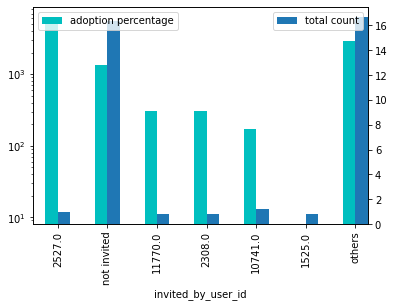

In [64]:
plt.figure()

ax1 = plt.gca()
ax2 = ax1.twinx()

invited_by_adopt.total_count.plot.bar(label = 'total count', position = 0, width = 0.25, ax = ax1)
(invited_by_adopt.adopted_rate*100).plot.bar(label = 'adoption percentage', color = 'c', position = 1, width = 0.25, ax = ax2)
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper left')
ax1.set_yscale('log')

Again the best test to run to determine the relationship between the invited by, and adopted users

The null hypothesis is that if a user is invited is independant to the adoption of that user
The alternate hypothesis is that if a user is invited is not independant of the adoption of that user

In [66]:
invite_table = pd.concat([(invited_by_adopt.total_count - invited_by_adopt.adopted_count), invited_by_adopt.adopted_count], axis=1)
invite_table.columns = ["nonadopted_count", "adopted_count"]
invite_table

,nonadopted_count,adopted_count
invited_by_user_id,,
2527.0,10.0,2.0
not invited,4870.0,713.0
11770.0,10.0,1.0
2308.0,10.0,1.0
10741.0,12.0,1.0
1525.0,11.0,0.0
others,5421.0,938.0


In [67]:
_, p, _, _ = chi2_contingency(invite_table)
print('P-value for Invited by and Adoption: {}'.format(p))

P-value for Invited by and Adoption: 0.05238057162545333


While the p-value is close, it is not significant enough to reject the null hypothesis

### If users are invited by adopted users

In [71]:
invited_by_adopted_user = pd.merge(users.invited_by_user_id, pd.concat([users.object_id, adopted_users], axis=1), left_on="invited_by_user_id", right_on="object_id", how="left")["adopted_users"]
invited_by_adopted_user.name = "invited_by_adopted_user"
invited_by_adopted_user = invited_by_adopted_user.fillna("not invited")

print("Adoption rate - if users are invited by adopted users")
pd.crosstab(adopted_users, invited_by_adopted_user, normalize="columns")

Adoption rate - if users are invited by adopted users


invited_by_adopted_user,False,True,not invited
adopted_users,,,
False,0.866742,0.789242,0.872291
True,0.133258,0.210758,0.127709


It appears that the adoption rate is higher if a new user is invited by an adopted user

In [72]:
invited_adopted_table = pd.crosstab(invited_by_adopted_user, adopted_users)
invited_adopted_table

adopted_users,False,True
invited_by_adopted_user,,
False,4579,704
True,895,239
not invited,4870,713


Again the best way to determine if the variables are independant is a chi2 test

The null hypothesis is that an invite by an adopted user is independant of adoption of new users
The alternate hypothesis is that an invite by an adopted user is not independant of adoption of new users

In [73]:
_, p, _, _ = chi2_contingency(invited_adopted_table)
print('P-value for invited adopted users:{}'.format(p))

P-value for invited adopted users:5.56436080629406e-13


With a p-value of 5.56e-13 we can conclude that the if a user is invited by an adopted user, is not independant of user adoption

In [74]:
invited_by_adopted_user_feature = invited_by_adopted_user
invited_by_adopted_user_feature

0              False
1              False
2               True
3               True
4               True
            ...     
11995          False
11996    not invited
11997          False
11998    not invited
11999    not invited
Name: invited_by_adopted_user, Length: 12000, dtype: object

### Logistic Regression Model

From above, the features we will use in the model are Email domain, Creation source, Time passed since user creation to last login, Organization_ID and If users are invited by adopted users, as features that will predict user adoption

In [78]:
X = pd.concat([email_domain_feature, last_login_feature,creation_feature, org_id_feature, invited_by_adopted_user_feature], axis = 1)
y = adopted_users

In [79]:
X.head()

,email_domain,last_login_since_first,creation_source,org_id,invited_by_adopted_user
0,yahoo.com,0,GUEST_INVITE,11,False
1,gustr.com,136,ORG_INVITE,1,False
2,gustr.com,0,ORG_INVITE,94,True
3,yahoo.com,1,GUEST_INVITE,1,True
4,yahoo.com,5,GUEST_INVITE,193,True


In [81]:
X.last_login_since_first = np.log10(X.last_login_since_first + 1)
X = pd.get_dummies(X)

X.head()

,last_login_since_first,email_domain_cuvox.de,email_domain_gmail.com,email_domain_gustr.com,email_domain_hotmail.com,email_domain_jourrapide.com,email_domain_others,email_domain_yahoo.com,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,...,org_id_410,org_id_411,org_id_412,org_id_413,org_id_414,org_id_415,org_id_others,invited_by_adopted_user_False,invited_by_adopted_user_True,invited_by_adopted_user_not invited
0,0.000000,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
1,2.136721,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.000000,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0.301030,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0.778151,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0


Used hot one encoding for all categorical variables and did a log(x+1) transformation on last_login_since_first to prepare data for modeling

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [85]:
train_last_login_since_first_mean = X_train.last_login_since_first.mean()
train_last_login_since_first_std = X_train.last_login_since_first.std()
X_train.last_login_since_first = (X_train.last_login_since_first - train_last_login_since_first_mean) / train_last_login_since_first_std
X_test.last_login_since_first = (X_test.last_login_since_first - train_last_login_since_first_mean) / train_last_login_since_first_std

Before modeling, needed to standardize the last login data

### Modeling

I will be using a logistic regression model as the results are going to be 0 non adopted or 1 adopted, followed by a gridsearch to find best parameters for accuracy

Text(0, 0.5, 'accuracy')

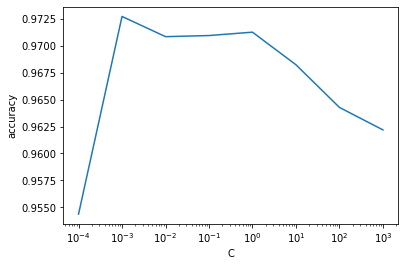

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(penalty="l2", solver="liblinear")
C_grid = {"C" : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
classifier = GridSearchCV(lr, C_grid, cv=20)
classifier.fit(X_train, y_train)

scores = classifier.cv_results_["mean_test_score"]
Cs = classifier.cv_results_["param_C"].data
plt.plot(Cs, scores)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("accuracy")

In [87]:
accuracy = np.mean(classifier.predict(X_test) == y_test)
print("Accuracy for the test set is {}.".format(accuracy))

Accuracy for the test set is 0.9575.
